# Exercise Class 1
This first exercise notebook aims to provide an intuition of how to train a model in PyTorch. First, we will briefly cover some basic concepts. Then, we will implement training schemes for
1. a binary classification of a 2-dimensional synthetic dataset.
2. a deep autoencoder for the Fashion-MNIST dataset.

This exercise is not directly relevant for the exam. Its goal is to simplify the start and setup for the projects.

If you do not have access to a GPU or prefer not to work locally, you may use [Google Colab](https://colab.research.google.com) (free version) as the workspace.

# PyTorch Basics

### The Tensor Class and Autograd




#### Tensor Data Structure

Let's start by introducing the main data structure in PyTorch.

The fundamental data structure in Pytorch is a "tensor". In this case, it refers to an array with arbitrary dimensions. It improves on ```numpy.array``` in the sense that it provides gradient computation semantics for tensors.

In [ ]:
import torch

# PyTorch Tensors are similar in behaviour to NumPy’s arrays.
a = torch.Tensor([[1,2],[3,4]])
print('a: ', a)
print('a**2: ', a**2) # it supports vertorization just like numpy.array

a:  tensor([[1., 2.],
        [3., 4.]])
a**2:  tensor([[ 1.,  4.],
        [ 9., 16.]])


There are two confusing ''calls'' of the tensor data structure. One is ```torch.Tensor``` and the other is ```torch.tensor```.

In fact, ```torch.Tensor``` is the class, and ```torch.tensor``` is a function which returns a Tensor.

The signature for this function is
```torch.tensor(data, *, dtype=None, device=None, requires_grad=False, pin_memory=False) → Tensor```. Note that the output type is ```torch.Tensor``` as claimed by the signature.

**For advanced readers: ```torch.Tensor``` is a family of tensors with different types. As stated on its [website](https://pytorch.org/docs/stable/tensors.html#), ```torch.Tensor``` is an alias for the default tensor type (torch.FloatTensor). A tensor of specific data type can be constructed by passing a ```torch.dtype```. To be more specific, in its underlying C++ implementation, each tensor containing different dtype has a declared type (recall C++ generic instantiates a new type when a new type parameter is passed).**

In [ ]:
# Both are of type torch.Tensor (because this is the class name).
print("a type:", type(a))
a2 = torch.tensor([[1,2],[3,4]])
print("a2 type:", type(a2))

# ---- Difference between torch.Tensor and torch.tensor ----
# 1. the data type is different for int inputs.
b = torch.tensor([2, 3])
b2 = torch.tensor([2., 3.]) # a dot behind a int means a float in Python; this means the input for b2 is float.
c = torch.Tensor([2, 3])
print("b type:", b.dtype) # with torch.tensor, the data type is not adjusted
print("b2 type:", b2.dtype)
print("c type:", c.dtype) # with torch.Tensor, the input is automatically casted.

a type: <class 'torch.Tensor'>
a2 type: <class 'torch.Tensor'>
b type: torch.int64
b2 type: torch.float32
c type: torch.float32


In [ ]:
# 2. Initializing torch.Tensor with no param is allowed; but no param for torch.tensor is not allowed!
e1 = torch.Tensor()
print("e1 OK!")

# e2 = torch.tensor() # data is a required positional param!
# print("This leads to an error!")

e1 OK! tensor([]) torch.float32


In [ ]:
# You can always create an empty tensor though
e3 = torch.Tensor([])
e4 = torch.tensor([])
print(e3, e4)
print(e3.dtype, e4.dtype) # an empty tensor is a float32 (but this is an undefined behavior and should not be relied on)
# Why float32? This is because FloatTensor is the default.

tensor([]) tensor([])
torch.float32 torch.float32


In [ ]:
# Pytorch (and Python) is trying to be clever for you.
# Dividing torch.int64 by torch.int64 is safe: the results are floats! Note: this is different to C++.
print(3 / 2)
#b = torch.tensor([2, 3])
d = torch.tensor([2, 2])
print("d type:", d.dtype)
ratio = b / d
print("int/int Type:", ratio.dtype)
print("b / d:", ratio)

# This holds for Long as well in the recent versions of Pytorch. In the older versions, the following code would print 1, just like C++!
# Make sure to check unless you are super sure. Sometimes versions can be annoying for such bugs!
# However, you may want to avoid dividing long tensor with another long tensor.
# In the common practice, long tensors are almost always used to hold the label, and thus should not be used for any algebra operations such as + and /
# unless you are sure about this.
l1 = torch.LongTensor([3, 2])
#l1 = torch.tensor([3,2], dtype=torch.long) An equivalent way of defining long tensors
l2 = torch.LongTensor([2, 2])
print(l1 / l2)

1.5
d type: torch.int64
int/int Type: torch.float32
b / d: tensor([1.0000, 1.5000])
tensor([1.5000, 1.0000])


In [ ]:
tensor_1 = torch.tensor([1e20])
tensor_2 = torch.tensor([1e20])
print(tensor_1 * tensor_2)

torch.float32


tensor([1.0000e+38])

**LongTensor can overflow, unlike in normal Python. FloatTensor can give inf. Also as we will see floating point can be used only for gradients.**

#### Autograd Functionality

By default, a Pytorch tensor does not have autograd (short for automatic gradient computation) semantics. This is because autograd requires it to maintain the computational graph in order to compute the gradients, which could be costly.

To enable autograd, set ```requires_grad=True``` for your tensor. Note: in the older versions, a wrapper called ```torch.Variable``` is used for autograd, which is deprecated now. Unless you are unable to use a more recent version, avoid using ```torch.Variable```.

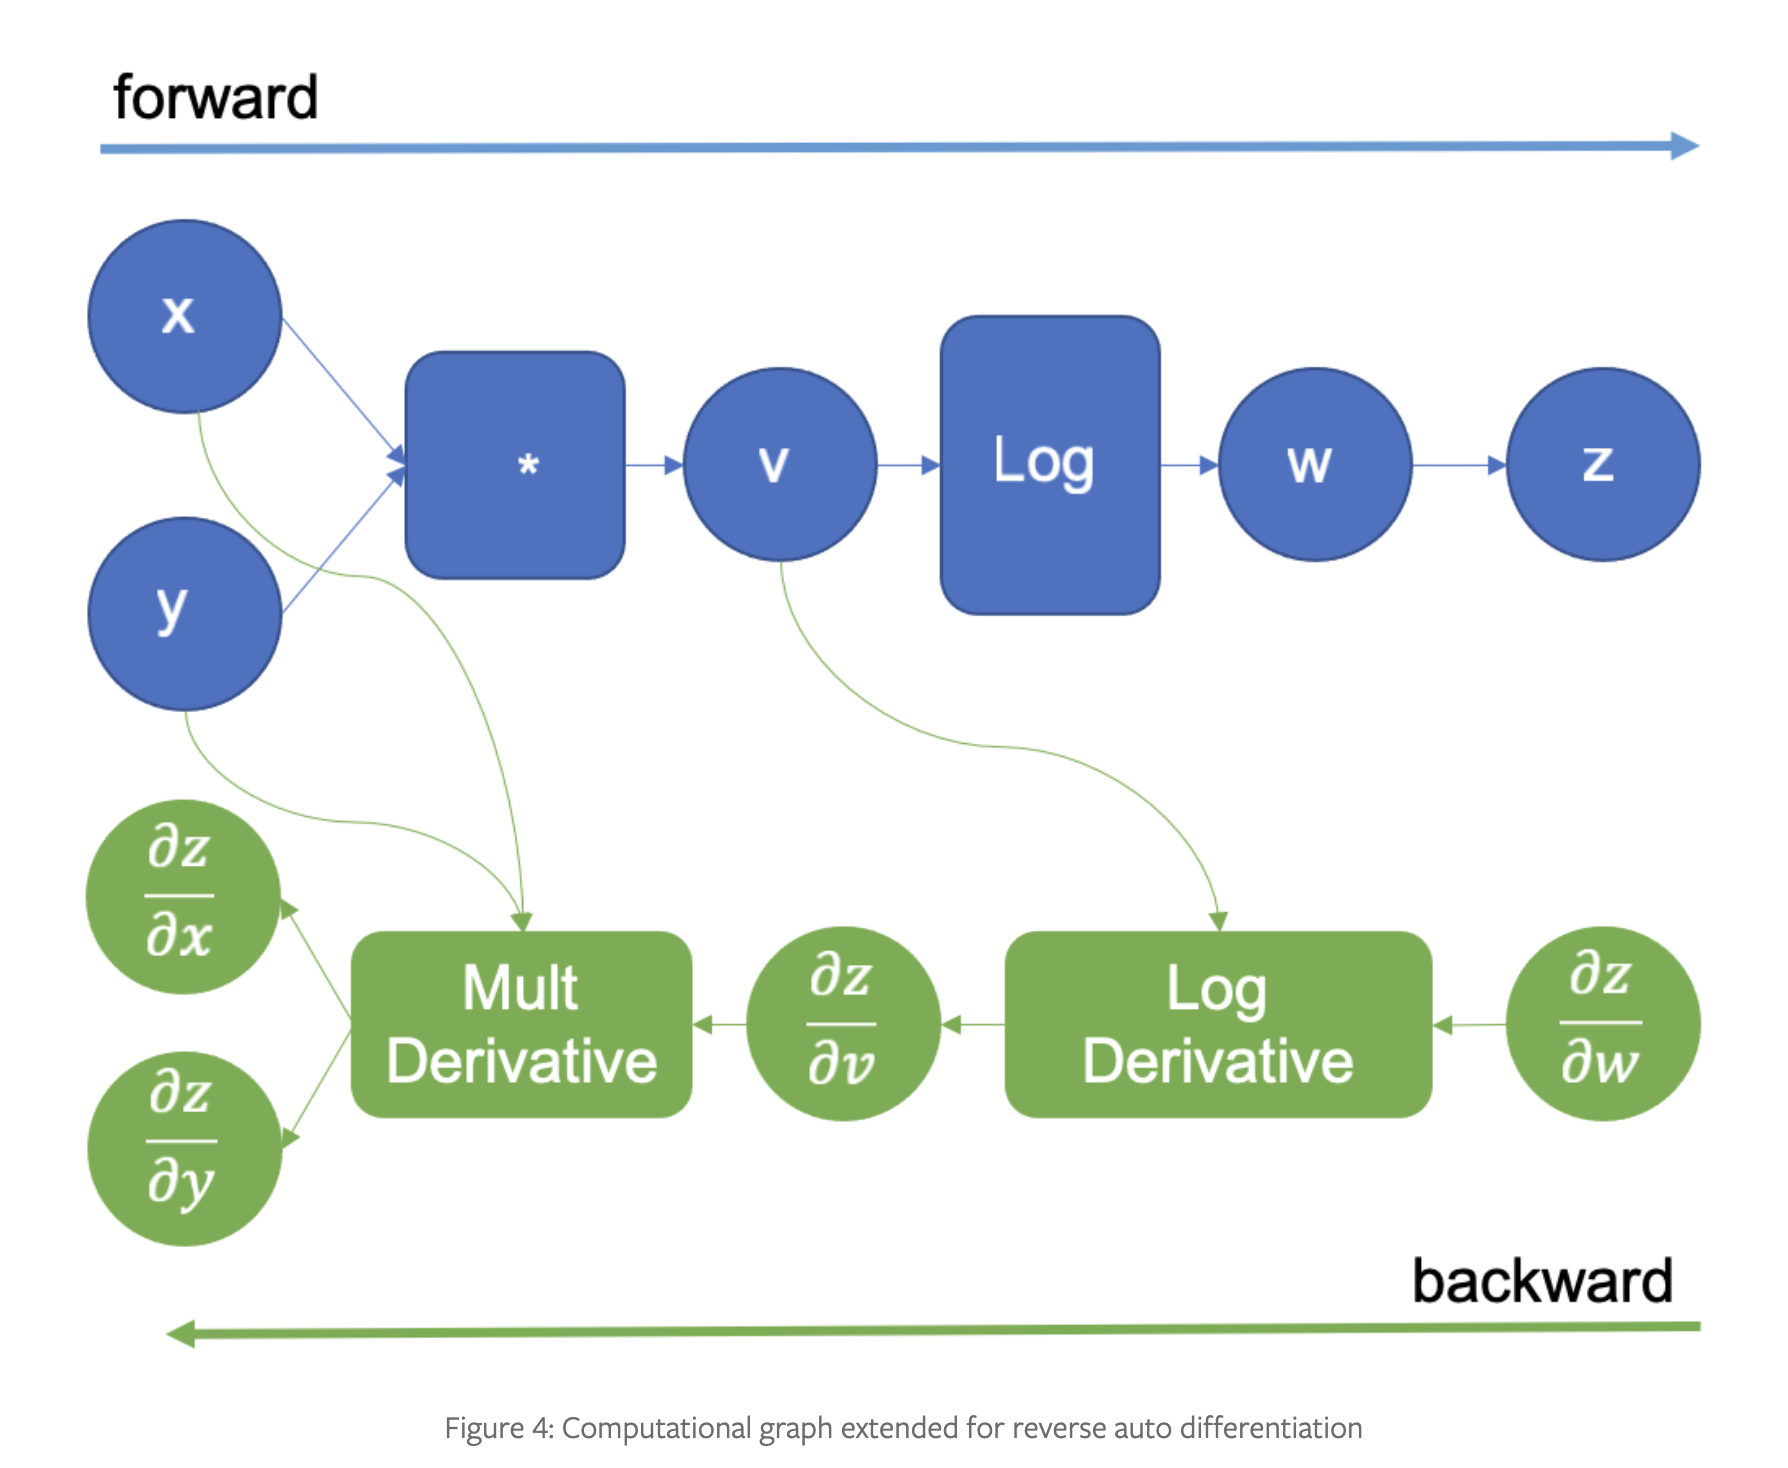
Example computational graph from https://pytorch.org/blog/overview-of-pytorch-autograd-engine/

In [ ]:
# dtype and requires_grad can be set when creating the tensor
# only Tensors of floating point and complex dtype can require gradients; thus no int and long tensor (gradients need continuous domain)
a = torch.tensor([[1,2],[3,4]], dtype=torch.float32, requires_grad=True)
print('a:\n', a) # now the message will additionally show requires_grad=True when printing this tensor

print("Before conversion:")
print(c)
c.requires_grad = True # changing requires_grad is also possible after its instantiation
print("Changed to requires_grad=True:\n", c)
c.requires_grad = False
print("Changed to requires_grad=False:\n", c)

a:
 tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
Before conversion:
tensor([2., 3.])
Changed to requires_grad=True:
 tensor([2., 3.], requires_grad=True)
Changed to requires_grad=False:
 tensor([2., 3.])


In [ ]:
# when performing differentiable operations on a tensor requiring grad, Pytorch builds the computational graph for us automatically.
# This leads to extra memory costs, but does not change the code.
# Pytorch does autograd by backward propagation. Details can be found at https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd
# Basically, it keeps how the variables are computed, and propagate the gradients by chain rule. It is a dynamic programming.
# We will cover backward propagation later in the course (neural network section) as well.
y = torch.sum(a**2) # 1 + 4 + 9 + 16
print('y: ', y) # a tensor that can be backwardly propagated has a grad_fn

# Compute gradients of y wrt a.
y.backward()
print('gradients: ', a.grad)

y:  tensor(30., grad_fn=<SumBackward0>)
gradients:  tensor([[2., 4.],
        [6., 8.]])


In [ ]:
# After a differentiation, Pytorch automatically removes the computational graph to save memory.
# This makes us unable to backward again.

# y.backward()
# print("This leads to an error!")

In [ ]:
# If you really want to backward again and does not care about the memory usage, set retain_graph=True when doing backward.
# This asks Pytorch to keep the computational graph.

a.grad = None # remove the grad we computed before
y = torch.sum(a**2)
y.backward(retain_graph=True) # this computes grad while keeping the computational graph
print(a.grad)

a.grad = None
y.backward() # this computes grad and removes the computational graph
print(a.grad)

tensor([[2., 4.],
        [6., 8.]])
tensor([[2., 4.],
        [6., 8.]])


**If we don't reset grad then it will add up automatically!**

To reuse the code, sometimes you don't want to switch the ```requires_grad``` flag frequently. Guess how messy it would look like in your code!

Therefore, in order to disable autograd for tensors requiring grad, which is commonly used when testing a fixed model, we can use the ```torch.no_grad()``` decorator.

In [ ]:
a.grad = None
with torch.no_grad():
    y = torch.sum(a**2)
print(y) # note that now y does not have a grad_fn and thus calling y.backward would lead to an error.

# Similarly, there is a decorator to enable autograd for tensors requiring grad. It is often used inside torch.no_grad() if necessary
with torch.no_grad():
    with torch.enable_grad():
        y = torch.sum(a**2) # this now creates the computational graph
    y.backward() # this works because torch.no_grad just prevents creating the computational graph, but does not remove an existing computational graph
print(a.grad)

tensor(30.)
tensor([[2., 4.],
        [6., 8.]])


**For .backward() to work the computational graph must be fully existant, that is, when the computation happened, all leaf tensors must have had their grad turned on.**

#### Working with GPU

You may have heard that Pytorch is good at working with GPUs and CUDA. Yes! Don't be scared of GPUs, you can do this by moving the tensor into the device by calling ```tensor.to(device)```.

In [ ]:
# On Google Colab, you can enable gpu support by Edit -> Notebook Settings -> Hardware Support, then restart the kernel.
device = "cuda" if torch.cuda.is_available() else "cpu" # check whether you have cuda support
print(f"Will use {device}")
# If you believe you should have cuda but device="cpu" anyways, it is possible that you installed the cpu-only version of Pytorch
# Check https://pytorch.org/get-started/locally/

print(a) # by default, a tensor is in the CPU memory
a = a.to(device)
print(a) # see device="cuda:0", right? 0 here means the GPU index (a program can use multiple GPUs)

# You can create tensors directly on GPUs. This is faster than moving via to(device)
# Check https://fleuret.org/dlc/materials/dlc-handout-6-6-using-GPUs.pdf
b = torch.rand_like(a, device="cuda")
print(b)

Will use cuda
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[1., 2.],
        [3., 4.]], device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([[0.7894, 0.6953],
        [0.2314, 0.5923]], device='cuda:0')


Copying a class could be expensive. Therefore, Python tries to do everything with aliasing when handling a class, which includes a torch.Tensor. This could lead to problems when you (accidentally) change a leaf variable when maintaining the computational graph. A leaf variable is a variable that does not depend on other variables. In Pytorch, this means a leaf variable is a tensor with ```requires_grad=True``` and does not have a ```grad_fn```.

In [ ]:
a = torch.rand(5, requires_grad=True)
b = a
print(a)
print(b is a)

c = torch.sum(a**2)
print(c)
# b[0] = 1 # not allowed since a is changed while it is in the computational graph
# print("This leads to an error!")

tensor([0.3129, 0.8831, 0.2659, 0.6149, 0.2927], requires_grad=True)
True
tensor(1.4122, grad_fn=<SumBackward0>)


In [ ]:
# We can copy the tensor in order to avoid this
b = a.clone()
b[0] = 1
print(a)
print(b) # Note: b has a grad_fn, why? Copying, slicing and selecting is also differentiable!

b = b.detach() # remove the gradient attachment from b to a
print(b) # no grad_fn any more, right?

tensor([0.3129, 0.8831, 0.2659, 0.6149, 0.2927], requires_grad=True)
tensor([1.0000, 0.8831, 0.2659, 0.6149, 0.2927], grad_fn=<CopySlices>)
tensor([1.0000, 0.8831, 0.2659, 0.6149, 0.2927])


In [ ]:
# check GPU status
# !cmd means to run cmd in the terminal (feature of IPython)

# ! calls out to a shell (in a new process),
# while % affects the process associated with the notebook
# (or the notebook itself; many % commands have no shell counterpart).
# Check https://stackoverflow.com/questions/45784499/what-is-the-difference-between-and-in-jupyter-notebooks?rq=1

!nvidia-smi
# Unfortunately, Colab does not support this command well.
# This means you cannot see the processing taking the memory.
# However, you can still see the memory cost of your GPU.
#  (possibly to protect other GPUs on the same machine which should not be viewed by you)
# How to read the table: https://medium.com/analytics-vidhya/explained-output-of-nvidia-smi-utility-fc4fbee3b124

Wed Feb 21 14:33:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              27W /  70W |    121MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Advanced / interested readers only:
# If you insist on monitoring with python code, you may use the following code snippet taking from https://colab.research.google.com/drive/1P7okDVh6viCIOkii6UAF2O9sTAcKGNWq#scrollTo=vSUyw1sgPtM8
%pip install gputil
%pip install psutil
%pip install humanize

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=4b6de270766d57ccda0375d2edd7ec0d22c9386ef1b073853c5ab4d8d6bb5a01
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

# Execute function
mem_report()

CPU RAM Free: 11.9 GB
GPU 0 ... Mem Free: 14981MB / 15360MB | Utilization   1%


Useful tricks to work with CUDA:

- Run ```nvidia-smi``` to check your GPU status. It will show the memory usage and workload of each GPU.

- Pytorch automatically does garbage collection when a function call is finished. Although you may manually delete an unwanted tensor, this is often unnecessary and has the potential to lower the performance. This is because Pytorch does not release allocated memory immediately when it no longer needs it. Pytorch releases memory only when an overflow would happen if it does not release. It works like this to avoid frequently asking for additional memory. Instead, it now uses the allocated but free memory. A rule of thumb is to **not** manually delete unwanted tensors if this is not necessary. For more details, check https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-management (for advanced users only).

- Make sure to check your memory usage is not accumulated through steps. This often happens if your code does not release unwanted tensors properly. For example, this could happen if you always call backward with ```retain_graph=True```.

Congratulations!

So far, you have known all Pytorch (just kidding). However, all the rest, including the fancy neural networks, are basically applying the autograd functionality on some predefined wrappers.

We discuss how to train a neural network below on a naive classification task. For all such tasks, you may follow a similar (almost identital) setup.

### Training a Model with Gradients

When we train a model in PyTorch, we usually follow the same 5 steps:
1. Compute the model's output (forward pass) by passing a batch of inputs.
```
output_batch = model(train_batch)
```
2. Calculate the loss.
```
loss = loss_fn(output_batch, labels_batch)
```
3. Clear the previous gradients.
```
optimizer.zero_grad()
```
4. Compute gradients of loss wrt to all the variables.
```
loss.backward()
```
5. Update the model's parameters using the computed gradients.
```
optimizer.step()
```

Lost? Let's learn with examples.

#### Defining the Models
A model can be defined in PyTorch by subclassing the ```torch.nn.Module``` class. The model is defined in two steps. We first specify the parameters of the model, and then outline how they are applied to the inputs.

In [ ]:
import torch.nn as nn # this library defined all you need for layers in a neural network

# Make sure to inherit from nn.Module: this module provides all dirty functions which are none of your business if you are not interested
class TwoLayerNet(nn.Module):
    # yeah, you need to initialize the model, right?
    def __init__(self, d_in, H, d_out):
        """
        d_in: input dimension
        H: dimension of hidden layer
        d_out: output dimension
        """
        super().__init__()
        # nn.Sequential is a wrapper class for combining a list of layers sequentially.
        # When called, it feeds the input to the first layer, then feeds the output of the first layer to the next one, repeatedly through all layers.
        self.model = nn.Sequential(
            # Unfamiliar with layers? Check https://pytorch.org/docs/stable/nn.html
            nn.Linear(d_in, H),
            nn.ReLU(), # Check https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity for more activations.
            nn.Linear(H, d_out),
        )

    # __init__ and forward are the only two methods required by Pytorch (the former by Python actually). Neat?
    def forward(self, x):
        """
        In the forward function we accept input data and we must
        return the model's output. We can use Modules defined in the
        constructor as well as arbitrary operators on the inputs.
        """
        y_pred = self.model(x)
        # A model (subclass of nn.Module) is callable because we have __call__ method defined in nn.Module which calls self.forward.
        # This is why we can customize self.forward only here.
        return y_pred

#### Defining the Dataset

A dataset is defined by inheriting from ```torch.utils.data.Dataset```. Note: if you think the importing path is too long, you may want to make sure your colleages understand your work since your code might not be modularized 🚑.



In [ ]:
from torch.utils.data import Dataset # this is the class for datasets
from torchvision import datasets # this module provides some common datasets
# torchvision.transform provides many useful transformation on images.
# Here we use ToTensor which converts an array-like input to tensor.
# Check https://pytorch.org/vision/stable/transforms.html for all predefined transformations.
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(
    root="data", # where you want to put the downloaded dataset
    train=True, # indicates whether you want the train set
    download=True, # download the dataset if it is not yet in your root; otherwise skip
    transform=ToTensor() # defines the transformation of the input image; the last step is almost always ToTensor
)
# You can use Compose to apply a list of transformation sequentially:
#  https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


 With a typical image dataset (not tensor dataset!), the dataset is actually not loaded into the memory.
 Loading the the data (and only the wanted data) is the job of DataLoader. In addition, it is often useful to only differentiate w.r.t. a batch of data, i.e., applying stochastic gradient methods. Therefore, we need to efficiently draw batches from our dataset. These are the functionalities of DataLoader.

To do this, we can use ```torch.utils.data.DataLoader```. It provides fast and multi-processing utilities for drawing the batches and loading the batches into the memory.

In [ ]:
from torch.utils.data import DataLoader
# batch_size is recommended to be set as the power of 2, e.g., 64, 128, 256, etc.
# This is because GPU works better with these numbers
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0)
# num_workers specifies the number of processes that are used to load data.
# Unless your system resource is limited, setting it to a larger number could improve your data loading efficiency.
# Depending on your Pytorch version and system, this is also a very error-proning functionality.
# Setting num_workers=0 is always a safe option.
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

#### Iterating over the Dataset

In [ ]:
print("Number of batches:", len(train_dataloader)) # there are 235 batches in the train data;
print("Input shape:", next(iter(train_dataloader))[0].shape) # each batch is of shape (256, 1, 28, 28)


model = TwoLayerNet(1*28*28, 32, 10)
model = model.to(device) # move the model to the device

from tqdm.auto import tqdm # show the status bar

def test_model(test_dataloader, model):
    num_correct, num_total = 0, 0
    ## Iterate over the full data once
    with torch.no_grad():
        for x, y in tqdm(test_dataloader):
            # reshape x to be one dimensional because our net accepts a one-dim input
            # you may do this by adding the flatten layer in the model instead
            x = x.view(x.shape[0], -1)
            x, y = x.to(device), y.to(device)
            output = model(x) # the output of the model
            pred = output.argmax(dim=1) # get the label with the highest predicted score as our prediction
            num_total += len(x)
            num_correct += torch.sum(pred == y).item() # we can get the value of a single-element tensor by calling item()
    print("Test Accuracy:", num_correct / num_total)


# the random model should get roughly the random-guess accuracy: 10%
test_model(test_dataloader, model)

Number of batches: 235
Input shape: torch.Size([256, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 0.1007


**It is crucial that both the model and all the inputs are on the same device for all computations.**

#### Training the Model

We train a model by minimizing some loss functions. There are many loss functions predefined in Pytorch. Check https://neptune.ai/blog/pytorch-loss-functions for more details.

The most frequently used loss function for classification is the cross entropy loss. You can find its mathematical properties in the above link.

Now we show how to train the model with cross entropy loss and stochastic gradient descent.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # self.parameters() is a helper function defined for nn.Module class
loss_fn = torch.nn.CrossEntropyLoss()

def train_one_epoch(train_dataloader, model, optimizer, loss_fn):
    with torch.enable_grad(): # this can be omitted
        for x, y in tqdm(train_dataloader):
            x = x.view(x.shape[0], -1)
            x, y = x.to(device), y.to(device)
            output = model(x)

            # compute loss, gradient, then update
            loss = loss_fn(output, y)
            optimizer.zero_grad() # clean the current grad stored on the variables
            loss.backward()
            optimizer.step() # update the model according to the grad

    return model

model = train_one_epoch(train_dataloader, model, optimizer, loss_fn)
test_model(test_dataloader, model) # after one iteration over the data, the accuracy improves largely

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 0.5895


In [ ]:
# Now let's do more iteration.
# The performance increases along the way.
# If you train for enough iterations, the model will finally converge
num_epoch = 5
for epoch_idx in range(num_epoch):
    print(f"Epoch {epoch_idx}")
    model = train_one_epoch(train_dataloader, model, optimizer, loss_fn)
    test_model(test_dataloader, model)

Epoch 0


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 0.6712
Epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 0.6986
Epoch 2


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 0.7283
Epoch 3


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 0.7447
Epoch 4


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 0.7628


Big congratulations! Now you are really getting the basic usage of Pytorch. This is already sufficient for CIL. You may choose more advanced optimizer such as Adam, more advanced training techniques such as learning rate scheduling, and more advanced model such as CNN and ResNet if you want to improve your model. Pytorch is merely a framework to help you efficiently train your model.

# Exercise 1 - 2D Points Classification
Train the TwoLayerNet from before to classify 2-dimensional points into two classes.

## Imports
First, we import the packages that we'll need.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
import math
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Create the Dataset
We create a synthethic dataset of points in 2 dimensions that belong to either of 2 classes.

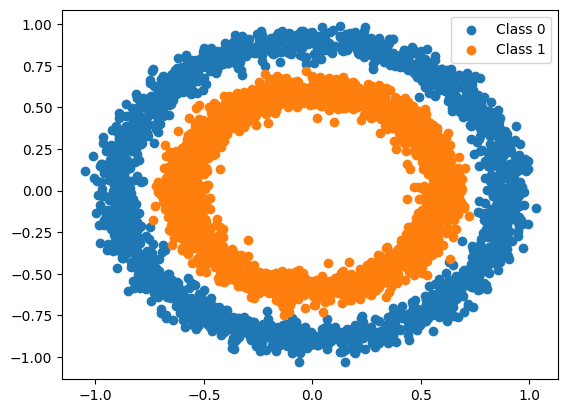

In [ ]:
N = 2000
batch_size = 64

def random_point_circle(radius, eps=0.1):
    # random angle
    alpha = 2 * math.pi * np.random.random()
    r = radius + eps * np.random.normal()
    return (r * math.cos(alpha), r * math.sin(alpha))

class_0_points = np.array([random_point_circle(0.9, 0.05) for _ in range(N)])
class_1_points = np.array([random_point_circle(0.6, 0.05) for _ in range(N)])

X = np.concatenate([class_0_points, class_1_points])
y = [0] * N + [1] * N
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

plt.figure()
plt.scatter(class_0_points[:, 0], class_0_points[:, 1], label='Class 0')
plt.scatter(class_1_points[:, 0], class_1_points[:, 1], label='Class 1')
plt.legend()
plt.show()

train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)),
    batch_size=batch_size)
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)),
    batch_size=batch_size)


## Train the Model - TODO
Please implement the 'train' function to train the TwoLayerModel to classify the 2-dimensional synthetic data points into Class 0 and Class 1.

Epoch 1/5, Train Loss: 0.684, Test Accuracy: 63.00%


Epoch 2/5, Train Loss: 0.641, Test Accuracy: 76.25%


Epoch 3/5, Train Loss: 0.554, Test Accuracy: 88.00%


Epoch 4/5, Train Loss: 0.427, Test Accuracy: 97.00%


Epoch 5/5, Train Loss: 0.301, Test Accuracy: 98.75%


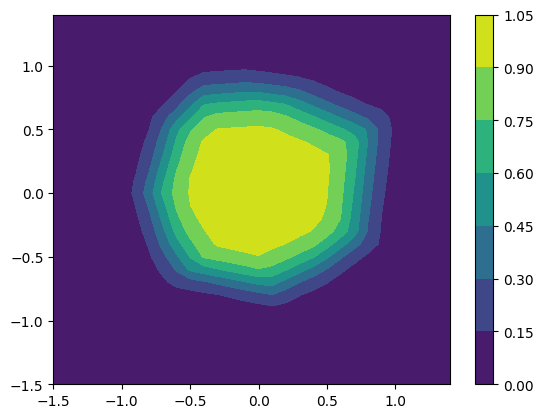

In [ ]:
# Parameters
batch_size = 128
num_epochs = 5
learning_rate = .5

model = TwoLayerNet(2, 16, 1)

# Loss function & optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),
                       lr=learning_rate)

def train(model, train_loader, test_loader, num_epochs=num_epochs):
    """Train the model."""
    for epoch in range(num_epochs):
        iteration_loss = 0.
        for batch in tqdm(train_loader, leave=False):
            # Load the next batch of images and transfer them to GPU.
            X, label = batch

            # Reset the optimizer.
            optimizer.zero_grad()

            # Do the forward pass of the autoencoder.
            outputs = model(X)
            # Compute the loss and do the backward pass.
            loss = loss_fn(outputs.squeeze(), label) # need to squeeze from (64, 1) to (64,)
            loss.backward()
            optimizer.step()

            iteration_loss += loss.item() #.item() retrieves a scalar from a tensor

        print(f'Epoch {epoch+1}/{num_epochs}, ' \
              f'Train Loss: {iteration_loss / len(train_loader):.3f}, ' \
              f'Test Accuracy: {compute_test_accuracy(model, test_loader)*100:.2f}%')

def compute_test_accuracy(model, test_loader):
    accuracy = []
    for batch in tqdm(test_loader, leave=False):
        X, label = batch
        outputs = model(X)
        acc = [1. if (out >= 0 and target == 1) or (out < 0 and target == 0) else 0.
        for out, target in zip(outputs.squeeze(), label)]
        accuracy.extend(acc)
    return np.mean(accuracy)

def plot_decision_boundary(model):
    # Plotting decision regions.
    x_min, x_max = - 1.5, 1.5
    y_min, y_max = - 1.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))
    X = np.concatenate((np.ones((xx.shape[0]*xx.shape[1],1))
                    ,  np.c_[xx.ravel(), yy.ravel()]), axis = 1)
    outputs = model(torch.Tensor(np.c_[xx.ravel(), yy.ravel()])).squeeze()
    outputs = torch.sigmoid(outputs.data)
    plt.contourf(xx, yy, outputs.data.reshape(xx.shape))
    plt.colorbar()
    plt.show()


train(model, train_loader, test_loader)
plot_decision_boundary(model)

# Exercise 2 - Autoencoder for FashionMNIST

In this exercise, we will implement a simple autoencoder for the Fashion-MNIST dataset as depicted in the image below.


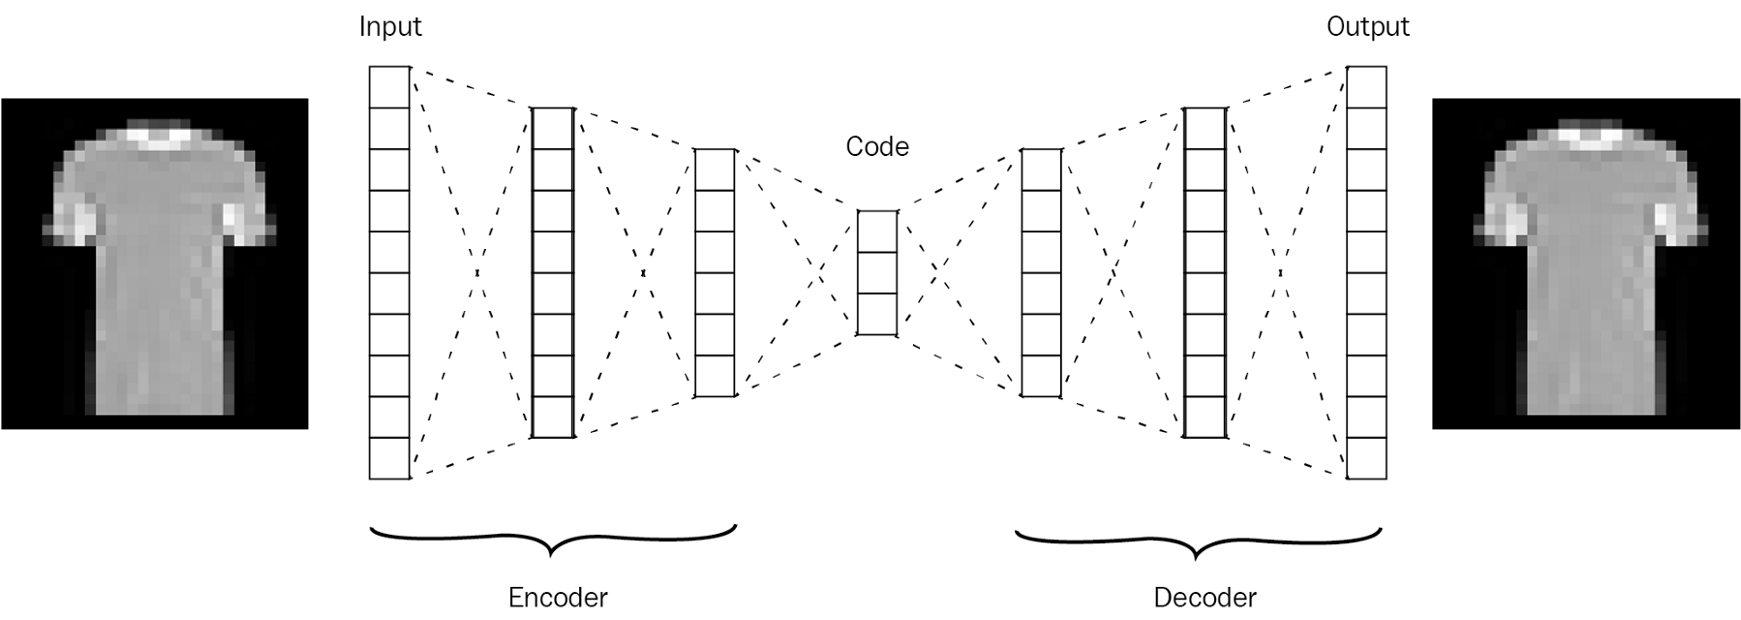

## Imports
First, we import the packages that we'll need.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
import math
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Data
Next, we download and inspect the Fashion MNIST data is provided through keras.datasets.

4422102/4422102 [==============================] - 0s 0us/step


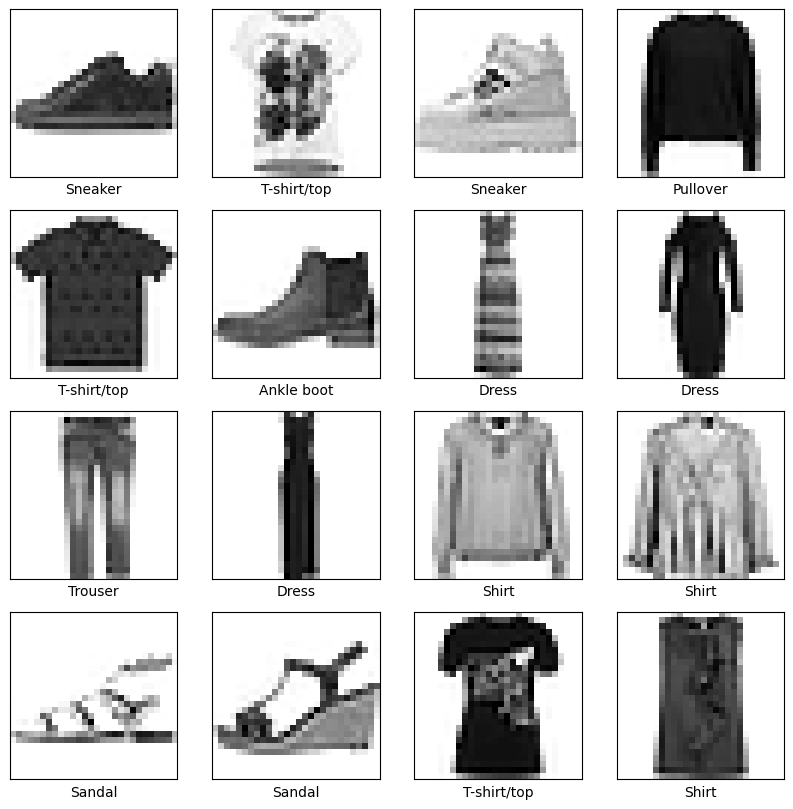

In [ ]:
# Load the FashionMNIST data.
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

def scale(data):
    """Cale the grayscale value to be in [0, 1] instead of [0, 256]."""
    return data / 255.

trainX = scale(trainX)
testX = scale(testX)

fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def visualize_sample(images, labels):

    plt.figure(figsize=(10,10))
    for c, idx in enumerate(np.random.choice(len(images), size=16)):
        plt.subplot(4, 4, c+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx], cmap=plt.cm.binary)
        plt.xlabel(fmnist_class_names[labels[idx]])
    plt.show()

visualize_sample(trainX, trainy)

## Model
Let's build the first autoencoder model. An autoencoder consists of an encoder and a decoder. The encoder maps from the initial (large) image dimension to a smaller latent representation. The decoder does the opposite steps, it takes the latent representation and reconstructs the image.

In [ ]:
class Encoder(nn.Module):
    """An encoder that flattens the image first and then only
    uses linear layers.

    Parameters:
        image_dimension (Tuple(int, int)): The image dimension of a single
            image.
        encoded_dimension (int): The dimension for the final encoding. Should
            be smaller than 32.
    """
    def __init__(self, image_dimension, encoded_dimension=16):
        super().__init__()

        flat_image_dimension = image_dimension[0] * image_dimension[1]
        self.model = nn.Sequential(
            nn.Linear(in_features=flat_image_dimension, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=encoded_dimension),
            nn.ReLU(),
        )

    def forward(self, images):
        """Encode the image."""
        batch_size = images.shape[0]
        flat_images = images.view(batch_size, -1) # -1 means the rest is collapsed into 1D
        return self.model(flat_images)


class Decoder(nn.Module):
    """A decoder that only uses linear layers. It's the counterpart to
    the Encoder.

    Parameters:
        image_dimension (Tuple(int, int)): The image dimension of a single
            image.
        encoded_dimension (int): The dimension for the final encoding. Should
            be smaller than 32.
    """
    def __init__(self, image_dimension, encoded_dimension=16):
        super().__init__()

        self.image_dimension = image_dimension
        flat_image_dimension = image_dimension[0] * image_dimension[1]
        self.model = nn.Sequential(
            nn.Linear(in_features=encoded_dimension, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=flat_image_dimension),
            nn.Sigmoid(), # Because the image should be in [0, 1].
        )

    def forward(self, encodings):
        """Decode the latent representation."""
        batch_size = encodings.shape[0]
        flat_images = self.model(encodings)
        images = flat_images.view(batch_size, *self.image_dimension) # * puts the tuple elements as individual inputs
        return images


class AutoEncoder(nn.Module):
    """Autoencoder model.

    Parameters:
        encoder: An encoder model.
        decoder: A decoder model.
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images):
        return self.decoder(self.encoder(images))

## Training - TODO
Now that we have defined the first simple autoencoder model, we need to train it.

<ipython-input-67-8d2eef2f68b3>:67: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  TensorDataset(torch.Tensor(trainX), torch.Tensor(trainy)),


Epoch 1/5, Train Loss: 0.044


Epoch 2/5, Train Loss: 0.027


Epoch 3/5, Train Loss: 0.025


Epoch 4/5, Train Loss: 0.023


Epoch 5/5, Train Loss: 0.021


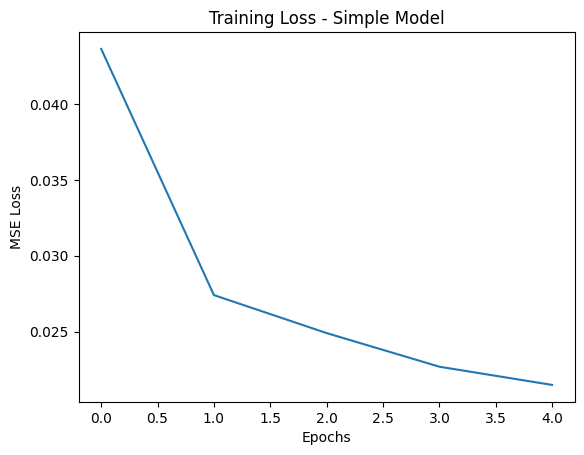

In [ ]:
# Parameters
batch_size = 64
num_epochs = 5
encoded_dimension = 16
learning_rate = 1e-3
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # makes the code very portable

# Model
autoencoder = AutoEncoder(
    encoder=Encoder(
        image_dimension=trainX.shape[1:], # image size ignoring batch size
        encoded_dimension=encoded_dimension,
    ).to(device),
    decoder=Decoder(
        image_dimension=trainX.shape[1:],
        encoded_dimension=encoded_dimension,
    ).to(device)
)

# Loss function & optimizer
loss_fn = nn.MSELoss() # Mean squared error
optimizer = optim.Adam(autoencoder.parameters(),
                       lr=learning_rate)


def train(autoencoder, train_loader, num_epochs=num_epochs):
    """Train the autoencoder.

    Parameters:
        autoencoder (nn.Module): The autoencoder model.
        train_loader (DataLoader): A Pytorch Dataloader containing the training
            images.
        num_epochs (int): The number of epochs to train.

    Returns:
        A list of training losses. One for each epoch of training.
    """
    epoch_losses = []
    for epoch in range(num_epochs):
        iteration_loss = 0.
        for batch in tqdm(train_loader, leave=False):
            # Load the next batch of images and transfer them to GPU.
            images, label = batch
            images = images.to(device)

            # Reset the optimizer.
            optimizer.zero_grad()

            # Do the forward pass of the autoencoder.
            outputs = autoencoder(images)

            # Compute the loss and do the backward pass.
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            iteration_loss += loss.item()

        epoch_losses.append(iteration_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_losses[-1]:.3f}')
        sleep(1.)

    return epoch_losses


# Build Dataloaders
train_loader = DataLoader( # here we have to build it manually
    TensorDataset(torch.Tensor(trainX), torch.Tensor(trainy)),
    batch_size=batch_size)
test_loader = DataLoader(
    TensorDataset(torch.Tensor(testX), torch.Tensor(testy)),
    batch_size=16)

epoch_losses = train(autoencoder, train_loader)

def plot_loss(epoch_losses, title='Train Loss'):
    plt.figure()
    plt.plot(epoch_losses)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.show()

plot_loss(epoch_losses, 'Training Loss - Simple Model')

## Evaluate
Let's take a look at some of the reconstructions.

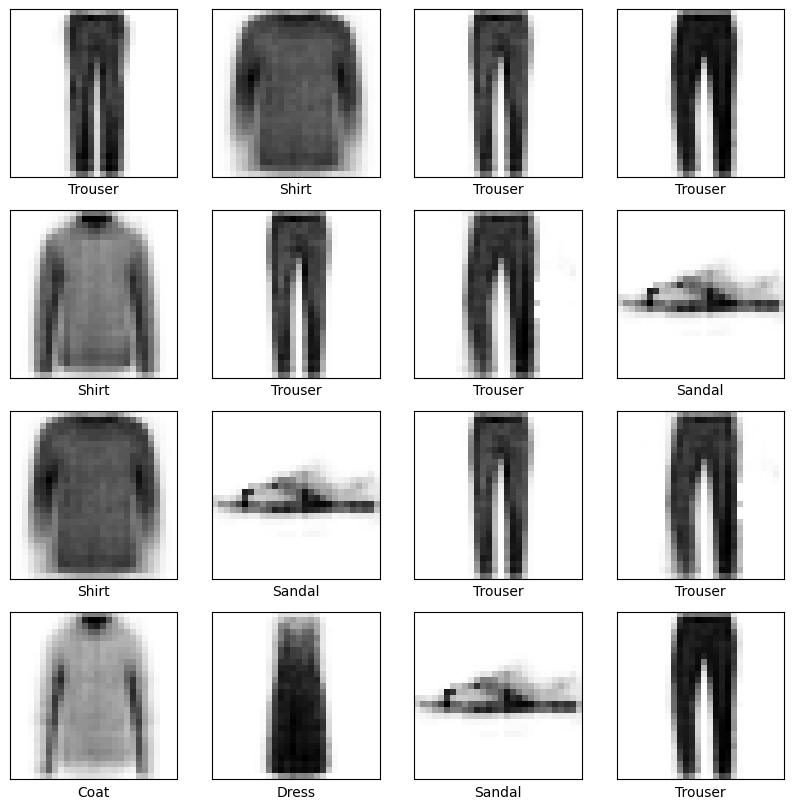

In [ ]:
def image_reconstruction(autoencoder, data_loader):
    images, labels = next(iter(data_loader)) # gets the first batch only
    images = images.to(device)

    reconstructed_images = autoencoder(images).cpu().data #.cpu() moves it to the CPU
    return reconstructed_images, [int(l) for l in labels.tolist()]

reconstructed_images, labels = image_reconstruction(autoencoder, test_loader)
visualize_sample(reconstructed_images, labels)